In [416]:
#Credentials
from azure.core.credentials import AzureKeyCredential
from msrest.authentication import CognitiveServicesCredentials
from msrest.authentication import ApiKeyCredentials

#Form Recognizer
from azure.ai.formrecognizer import FormRecognizerClient

# Azure Face model
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

# Video Indexer
from video_indexer import VideoIndexer

# Azure Predection Vision
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

# Other
import yaml
import io
import glob
import os
import sys
import time
import uuid
import requests
import datetime
import pandas as pd
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image as PILImage, ImageDraw
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline







## 1. Read Constants and initilize.

In [422]:
# read yaml Constants values
yaml_file = open("Constants.yaml")
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [366]:
# Form Recognizer Client
form_recognizer_client = FormRecognizerClient(
    endpoint=parsed_yaml_file['AzureFormRecognizer']['endpoint'], 
    credential=AzureKeyCredential(parsed_yaml_file['AzureFormRecognizer']['key'])
)

In [367]:
# Face Client
face_client = FaceClient(
    parsed_yaml_file['AzureFaceCognitiveService']['endpoint'], 
    CognitiveServicesCredentials(parsed_yaml_file['AzureFaceCognitiveService']['key'])
)

In [417]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": parsed_yaml_file['AzureComputerVision']['key']})
predictor = CustomVisionPredictionClient(parsed_yaml_file['AzureComputerVision']['endpoint'], prediction_credentials)

In [368]:
# Video Indexer 
video_analysis = VideoIndexer(
    vi_subscription_key=parsed_yaml_file['AzureVideoIndexer']['subscription_key'],
    vi_location=parsed_yaml_file['AzureVideoIndexer']['location'],
    vi_account_id=parsed_yaml_file['AzureVideoIndexer']['account_id']
)

# 2. Extract Text data from Id.
## 2.1 Helper Function

In [241]:
# Helper Function for processing the data.
def get_id_details(id):
    data_dic = {}
    probability = 0.5
    
    id_type = id.fields.get("driverLicense")
    if id_type and (id_type.confidence >= probability):
        data_dic['id_type']=id_type.value
        print("Receipt Type: {} has confidence: {}".format(id_type.value, id_type.confidence))

    documentNumber = id.fields.get("DocumentNumber")
    if documentNumber and (documentNumber.confidence >= probability):
        data_dic['documentNumber']=documentNumber.value
        print("Document Number: {} has confidence: {}".format(documentNumber.value, documentNumber.confidence))
    
    dateOfExpiration = id.fields.get("DateOfExpiration")
    if dateOfExpiration and (dateOfExpiration.confidence >= probability):
        data_dic['dateOfExpiration']=dateOfExpiration.value
        print("Date of Expiration: {} has confidence: {}".format(dateOfExpiration.value, dateOfExpiration.confidence))                

    countryRegion = id.fields.get("CountryRegion")
    if countryRegion and (countryRegion.confidence >= probability):
        data_dic['countryRegion']=countryRegion.value
        print("Country Region: {} has confidence: {}".format(countryRegion.value, countryRegion.confidence))
    
    region = id.fields.get("Region")
    if region and (region.confidence >= probability):
        data_dic['region']=region.value   
        print("Region: {} has confidence: {}".format(region.value, region.confidence))        
    
    firstName = id.fields.get("FirstName")
    if firstName and (firstName.confidence >= probability):
        data_dic['firstName']=firstName.value
        print("First Name: {} has confidence: {}".format(firstName.value, firstName.confidence))
    
    lastName = id.fields.get("LastName")
    if lastName and (lastName.confidence >= probability):
        data_dic['lastName']=lastName.value     
        print("Last Name: {} has confidence: {}".format(lastName.value, lastName.confidence))        
    
    dateOfBirth = id.fields.get("DateOfBirth")
    if dateOfBirth and (dateOfBirth.confidence >= probability):
        data_dic['dateOfBirth']=dateOfBirth.value
        print("Date of Birth: {} has confidence: {}".format(dateOfBirth.value, dateOfBirth.confidence))

    sex = id.fields.get("Sex")
    if sex and (sex.confidence >= probability):
        data_dic['sex']=sex.value   
        print("Sex: {} has confidence: {}".format(sex.value, sex.confidence))     

    return data_dic   
    

## 2.2 Extract Data

In [242]:
# Input Resource
id_path = parsed_yaml_file['Resources']['Driver_License_id']

# Extract Data
with open(id_path, "rb") as f:
    id_content = form_recognizer_client.begin_recognize_identity_documents(f)
collected_ids = id_content.result()
collected_ids

[RecognizedForm(form_type=prebuilt:idDocument:driverLicense, fields={'Address': FormField(value_type=string, label_data=None, value_data=FieldData(page_number=1, text=1234 Circle Ave, Apt 123 San Mateo, CA, 94401, bounding_box=[Point(x=180.0, y=149.0), Point(x=310.0, y=149.0), Point(x=310.0, y=176.0), Point(x=180.0, y=176.0)], field_elements=None), name=Address, value='1234 Circle Ave, Apt 123 San Mateo, CA, 94401', confidence=0.787), 'CountryRegion': FormField(value_type=countryRegion, label_data=None, value_data=None, name=CountryRegion, value='USA', confidence=0.99), 'DateOfBirth': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, text=11/05/1990, bounding_box=[Point(x=216.0, y=183.0), Point(x=275.0, y=182.0), Point(x=275.0, y=195.0), Point(x=216.0, y=195.0)], field_elements=None), name=DateOfBirth, value=datetime.date(1990, 11, 5), confidence=0.995), 'DateOfExpiration': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, tex

## 2.3 Results

Displaying id details ....... # 1
Document Number: D1345658 has confidence: 0.995
Date of Expiration: 2023-01-01 has confidence: 0.988
Country Region: USA has confidence: 0.99
Region: California has confidence: 0.99
First Name: BADR has confidence: 0.647
Last Name: ELFARRI has confidence: 0.824
Date of Birth: 1990-11-05 has confidence: 0.995
Sex: M has confidence: 0.985
---------------- EOL -------------------------


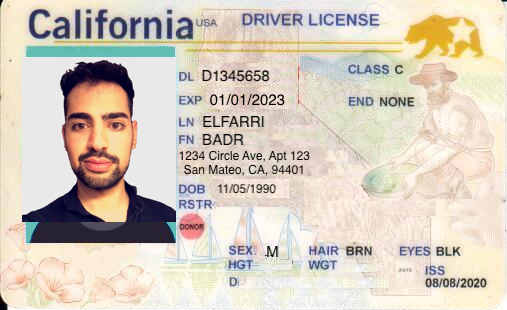

-----------------------------------------
Dictionary result:


{'documentNumber': 'D1345658',
 'dateOfExpiration': datetime.date(2023, 1, 1),
 'countryRegion': 'USA',
 'region': 'California',
 'firstName': 'BADR',
 'lastName': 'ELFARRI',
 'dateOfBirth': datetime.date(1990, 11, 5),
 'sex': 'M'}

In [243]:
id_dic_arr = []
for index_id, id in enumerate(collected_ids):
    print("Displaying id details ....... # {}".format(index_id+1))
    id_dic_arr.append(get_id_details(id))
    print("---------------- EOL -------------------------")

display(Image(id_path, width=600, height=350))

print("-----------------------------------------")
print('Dictionary result:')
results_driver_license = id_dic_arr[0]
results_driver_license

# 3. Extract Text data from Boarding Pass.

## 3.1 Extract Data from boardingPass using generated model

In [70]:
# Boarding Pass input:
boarding_pass_path = parsed_yaml_file['Resources']['Boarding_Pass']

# Extract data from local stored boarding pass.
with open(boarding_pass_path, "rb") as f:
    composed_model_testing = form_recognizer_client.begin_recognize_custom_forms(model_id=parsed_yaml_file['AzureFormRecognizer']['boardingPassModelId'], form=f)

# Status and results
print(composed_model_testing.status())
composed_model_testing_result = composed_model_testing.result()

InProgress


In [71]:
# Status
print(composed_model_testing.status())

succeeded


## 3.2 Results

In [72]:
boarding_pass_dic_arr = []
for recognized_content in composed_model_testing_result:
    boarding_pass_dic = {}
    print("Form type: {}".format(recognized_content.form_type))
    for name, field in recognized_content.fields.items():
        if field.confidence >= 0.7:
            boarding_pass_dic[name] = field.value
        print("Field '{}' has label '{}' with value '{}' and a confidence score of {}".format(
            name,
            field.label_data.text if field.label_data else name,
            field.value,
            field.confidence
        ))
    boarding_pass_dic_arr.append(boarding_pass_dic)


print('------------------------------------------')
print('dictionary results from boarding pass: ')
results_boarding_pass = boarding_pass_dic_arr[0]
results_boarding_pass


Form type: custom:Latest Model
Field 'GATE' has label 'GATE' with value 'A22' and a confidence score of 0.995
Field 'Destination' has label 'Destination' with value 'New York' and a confidence score of 0.994
Field 'Class' has label 'Class' with value 'A' and a confidence score of 0.99
Field 'Origin' has label 'Origin' with value 'San Francisco' and a confidence score of 0.99
Field 'Time' has label 'Time' with value '10:00' and a confidence score of 0.99
Field 'Date' has label 'Date' with value '10 July 2021' and a confidence score of 0.99
Field 'LastName' has label 'LastName' with value 'Elfarri' and a confidence score of 0.995
Field 'Baggage' has label 'Baggage' with value '1' and a confidence score of 0.994
Field 'Carrier' has label 'Carrier' with value 'KLM' and a confidence score of 0.994
Field 'FlightNo' has label 'FlightNo' with value 'UA-123' and a confidence score of 0.994
Field 'FirstName' has label 'FirstName' with value 'Badr' and a confidence score of 0.994
Field 'SeatNo' h

{'GATE': 'A22',
 'Destination': 'New York',
 'Class': 'A',
 'Origin': 'San Francisco',
 'Time': '10:00',
 'Date': '10 July 2021',
 'LastName': 'Elfarri',
 'Baggage': '1',
 'Carrier': 'KLM',
 'FlightNo': 'UA-123',
 'FirstName': 'Badr',
 'SeatNo': '2'}

# 4. Extract Data from Flight Manifest


In [217]:
def transform_date(str_date):
    return datetime.datetime.strptime(str_date, '%d %B %Y').date()

In [218]:
# Resource location in disk
manifest_file = parsed_yaml_file['Resources']['Boarding_Manifest']
# Read column names
columns_name = pd.read_csv(manifest_file, index_col=False, nrows=0).columns.tolist()
# Read pandas and set columns to lowercase
flight_Manifest = pd.read_csv(manifest_file, index_col=False, skiprows = 1, header = None, names= [name.lower() for name in columns_name]).apply(lambda x: x.astype(str).str.lower())
pd.set_option('display.max_columns', 18)

#flight_Manifest_m = flight_Manifest[['FlightNo', 'Origin', 'Destination', 'Date', 'Time', 'FirstName', 'LastName', 'Sex', 'SeatNo', 'DateOfBirth']]
# Transform date to datetime
flight_Manifest['date'] = flight_Manifest['date'].apply(transform_date)
flight_Manifest['dateofbirth'] = flight_Manifest['dateofbirth'].apply(transform_date)
result_flight_Manifest = flight_Manifest
result_flight_Manifest


,flightno,origin,destination,date,time,firstname,lastname,sex,seatno,dateofbirth,dobvalidation,personvalidation,luggagevalidation,namevalidation,boardingpassvalidation
0,ua-123,san francisco,new york,2021-07-10,10:00,avkash,chauhan,m,10a,1977-08-31,false,false,false,false,false
1,ua-123,san francisco,new york,2021-07-10,10:00,badr,elfarri,m,2,1990-11-05,false,false,false,false,false
2,ua-155,san francisco,oslo,2021-07-10,12:00,coolfirstname,boringlastname,f,10a,1980-08-05,false,false,false,false,false
3,ua-155,san francisco,oslo,2021-07-10,12:00,cooltwo,boringtwo,m,10a,1935-12-02,false,false,false,false,false
4,ua-155,san francisco,oslo,2021-07-10,12:00,coolthree,boringthree,f,10a,1900-07-01,false,false,false,false,false


# 5. Check lugage for lighter or no lighter

In [431]:
# Predection function
def perform_prediction(image_file_name):
    extracted_predection = []
    with open(os.path.join (parsed_yaml_file['AzureComputerVision']['local_image_path'],  image_file_name), "rb") as image_contents:
        results = predictor.detect_image(parsed_yaml_file['AzureComputerVision']['project_id'], parsed_yaml_file['AzureComputerVision']['iteration_name'], image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            extracted_predection.append(prediction.probability)
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))
    return extracted_predection

In [432]:
lighter_prediction = perform_prediction(parsed_yaml_file['AzureComputerVision']['image_name'])

	Lighter: 99.87%
	Lighter: 1.03%


# 6. Face Detection
## 6.1 read face from id picture

In [397]:
# Detect Face form an image
def detect_face_from(local_image=None, url_image=None):
    if url_image:
        detected_faces = face_client.face.detect_with_url(url_image, detection_model='detection_03')
    else:
        detected_faces = face_client.face.detect_with_stream(local_image, detection_model='detection_03')
    if not detected_faces:
        raise Exception('No face detected from image {}'.format(single_image_name))        
    print('Total face(s) detected  from {}'.format(str(len(detected_faces))))
    return detected_faces

In [398]:
# List all detected faces
def list_all_faces_from(detected_faces_object):
    print('We found total {} face(s) in selected face detected object.'.format(str(len(detected_faces_object))))
    for face in detected_faces_object: 
        print (face.face_id)

In [399]:
# Input Resource and extract results
with open(id_path, "rb") as f:
    detected_faces_object = detect_face_from(local_image=f)

Total face(s) detected  from 1


In [400]:
list_all_faces_from(detected_faces_object)
face_in_id = detected_faces_object[0].face_id

We found total 1 face(s) in selected face detected object.
cba5e454-79a7-4c2e-abb7-ea014676f552


## 6.2 read face from video

In [401]:
video_id = parsed_yaml_file['AzureVideoIndexer']['video_id']

In [402]:
# Check status once the videoAnalyzer is done indexing we will get use the object info that contains all hte information we need
info = video_analysis.get_video_info(video_id, video_language='English')

Getting video info for: faf7217f18


### 6.2.1 Extract thumbnails in the video

Getting thumbnail from video: faf7217f18, thumbnail: 76acd253-4096-4db9-b3d4-3e6cb2fa6293
Getting thumbnail from video: faf7217f18, thumbnail: 245fad7e-392e-4c27-ac95-617f1c6975f1
Getting thumbnail from video: faf7217f18, thumbnail: 27850c56-2b0a-4067-bb1e-e3871f7c1c31
Getting thumbnail from video: faf7217f18, thumbnail: 114d823f-aa82-4276-9ec8-7f1ee41bd380
Getting thumbnail from video: faf7217f18, thumbnail: de075155-9838-416f-9572-19b368bd65f5
Getting thumbnail from video: faf7217f18, thumbnail: d5309ad8-d9ee-4f0f-8a8a-61be29531f6e
Getting thumbnail from video: faf7217f18, thumbnail: 7efd2f5c-8157-4585-81fe-49c1dec8fc26
Getting thumbnail from video: faf7217f18, thumbnail: a364bcc1-4564-4ab4-8d92-e860d72f2d9f
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}


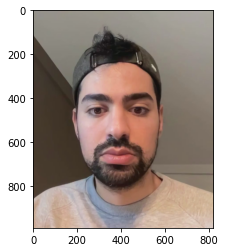

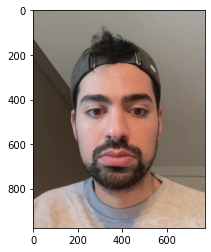

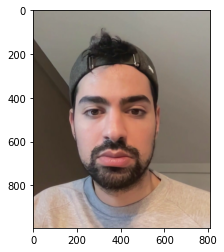

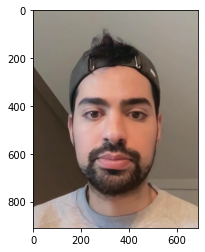

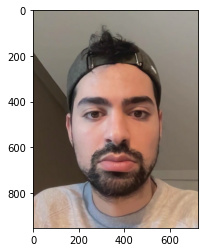

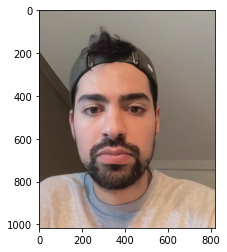

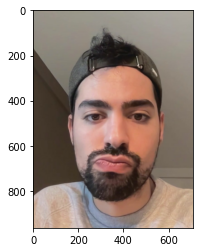

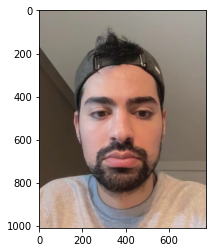

In [403]:
# Get thumbnail ids
images = []
img_raw = []
img_strs = []
for each_thumb in info['videos'][0]['insights']['faces'][0]['thumbnails']:
    if 'fileName' in each_thumb and 'id' in each_thumb:
        file_name = each_thumb['fileName']
        thumb_id = each_thumb['id']
        img_code = video_analysis.get_thumbnail_from_video_indexer(video_id,  thumb_id)
        img_strs.append(img_code)
        img_stream = io.BytesIO(img_code)
        img_raw.append(img_stream)
        img = PILImage.open(img_stream)
        images.append(img)


# Print Pictures extracted
for img in images:
    print(img.info)
    plt.figure()
    plt.imshow(img)



In [404]:
# Save pictures locally
i = 1
for img in images:
    print(type(img))
    img.save('human-face' + str(i) + '.jpg')
    i= i+ 1

# Check everything ok
!ls human-face*.jpg

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
human-face1.jpg human-face3.jpg human-face5.jpg human-face7.jpg
human-face2.jpg human-face4.jpg human-face6.jpg human-face8.jpg


### 6.2.2 Build a face model using extract pictures

In [405]:
## This code is taken from Azure Face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    human_person = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg human images in working directory.
    human_face_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]
    # Add images to a Person object
    for image_p in human_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, human_person.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)



In [406]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-BadrElfarri'
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: b5186f95-2f8e-4f19-b71a-4b598b211118
Training status: succeeded.


## 7 Validation of all results

In [407]:
# Constants
VERIFY = {
    'FirstName': False, 
    'LastName': False, 
    'Sex': False, 
    'DateOfBirth': False, 
    'FlightNo': False,
    'Origin': False,
    'Destination': False,
    'Date': False,
    'Time': False,
    'SeatNo': False
}

name_validation_fields = ['FirstName', 'LastName', 'DateOfBirth', 'Sex']
boarding_pass_validation_fields = ['FirstName', 'LastName', 'FlightNo', 'Origin', 'Destination', 'Date', 'Time', 'SeatNo']
date_of_birth_validation_fields = ['DoBValidation']


In [408]:
# Extracting a given key value. Helper function
def value_of_key(key, id, boarding, manifest):
    """Extracting a given key value from, id, boarding-pass and manifest

        Key is passed and a value extracted form dictionary of id, boarding and pandas 
        of manifest. Return array of values for a given key found in each collection.

        The id in this case driver license id and boarding pass are passed 
        as dictionaries while manifest is passed in as a pandas dataframe.
        From manifest we extract the record we are interrested in by matching 
        id first name, last name and boarding departure date to get a singel
        data for a passanger. we could expand on using date of birth as well.
    """
    key = key.lower()
    # id results lowercased
    id = {k.lower(): v if type(v)== datetime.date else v.lower() for k, v in id.items()}
    # boarding results lowercased
    boarding = {k.lower(): transform_date(v) if k == 'Date' else v.lower() for k, v in boarding.items()}
    # manifest
    manifest = manifest.loc[(manifest['firstname'] == id.get('firstname')) & (manifest['lastname'] == id.get('lastname')) & (manifest['date'] == boarding.get('date'))]
    manifest_dict = manifest.to_dict(orient='records')[0]

    arrayValues = []
    arrayValues.append(id.get(key)) if id.get(key) else print(key + ' not found in driver license') 
    arrayValues.append(boarding.get(key)) if boarding.get(key) else print(key + ' not found in boardingPass')    
    arrayValues.append(manifest_dict.get(key)) if manifest_dict.get(key) else print(key + ' not found in manifest')
    #print(arrayValues)
    return (arrayValues, manifest.index.values[0])


In [433]:
# Validate each data point
def validate_data(
    verify=VERIFY, 
    results_driver_license=results_driver_license, 
    results_boarding_pass=results_boarding_pass, 
    result_flight_Manifest=result_flight_Manifest, 
    manifest_file=manifest_file,
    face_in_id=face_in_id,
    person_group_id=PERSON_GROUP_ID,
    lighter_prediction=lighter_prediction):
    """Validate the extracted results from the different sources. return csv in DataFrame Format

    Args:
        verify (dictionary): contains all the fields to be validated
        results_driver_license: results extracted from the driver license id
        results_boarding_pass: results extracted from the boarding pass
        result_flight_Manifest: results extracted from the csv flight manifest 
        manifest_file: manifest location in disk

    Returns:
        PandasDataFrame: DataFrame containing the csv flight manifest with modified verification columns.
    """
    for key, value in verify.items():
        print('Validating ' + key.upper())

        # return array with values for passed key in the different results extracted from id, boarding pass and manifest
        (values, manifest_row_id) = value_of_key(key, results_driver_license, results_boarding_pass, result_flight_Manifest)
        
        # how many values do we expect the array shall include.
        how_many_values = 3 if key == 'FirstName' or key=='LastName' else 2
    
        if len(values)>=how_many_values and all(value==values[0] for value in values):
            print('Match!! 😃')
            verify[key] = True
        else:
            print('No Match 😭')
        
        print('**************************************************')
    
    # Check if face match
    print('Validating ' + 'Face')
    person_gp_results = face_client.face.identify([face_in_id], person_group_id)
    face_match_confidence = person_gp_results[0].candidates[0].confidence
    if face_match_confidence>=0.7:
        face_match = True
        print('Match!! 😃')
    else:
        face_match = False
        print('No Match 😭')
    print('**************************************************')

    # Checking if lighter is found
    print('Validating ' + 'Lighter Found')
    if lighter_prediction[0]>=0.7:
        lighter_found = True
        print('Match!! 😃')
    else:
        lighter_found = False
        print('No Match 😭')
    print('**************************************************')
    

    flight_Manifest = pd.read_csv(manifest_file, index_col=False)
    
    flight_Manifest.at[manifest_row_id,'NameValidation'] = all([value for key, value in verify.items() if key in name_validation_fields])
    flight_Manifest.at[manifest_row_id,'BoardingPassValidation'] = all([value for key, value in verify.items() if key in boarding_pass_validation_fields])
    flight_Manifest.at[manifest_row_id,'DoBValidation']  = all([value for key, value in verify.items() if key in date_of_birth_validation_fields])
    flight_Manifest.at[manifest_row_id,'PersonValidation']  = face_match
    flight_Manifest.at[manifest_row_id,'LuggageValidation']  = lighter_found


    return (flight_Manifest, manifest_row_id)#.at[manifest_row_id,'DoBValidation'] # manifest.index.values[0]


In [436]:
flight_Manifest = validate_data()

Validating FIRSTNAME
Match!! 😃
**************************************************
Validating LASTNAME
Match!! 😃
**************************************************
Validating SEX
sex not found in boardingPass
Match!! 😃
**************************************************
Validating DATEOFBIRTH
dateofbirth not found in boardingPass
Match!! 😃
**************************************************
Validating FLIGHTNO
flightno not found in driver license
Match!! 😃
**************************************************
Validating ORIGIN
origin not found in driver license
Match!! 😃
**************************************************
Validating DESTINATION
destination not found in driver license
Match!! 😃
**************************************************
Validating DATE
date not found in driver license
Match!! 😃
**************************************************
Validating TIME
time not found in driver license
Match!! 😃
**************************************************
Validating SEATNO
seatno not foun

In [439]:
#Write to csv file
flight_Manifest.to_csv(manifest_file, index=False)